In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:

data = pd.read_csv("./../data/credit44_sc.csv")

In [3]:
data = data.loc[: , ["SCORE_RK0400_000"   , "CNT_ENG" , "DAYS_CONTACT_POS" , "A_K_D10220000_OPR",  "AGE" , "SC0000049" ]]

In [4]:
col = data.columns

fac_var =["SCORE_RK0400_000"   , "CNT_ENG" , "DAYS_CONTACT_POS" , "A_K_D10220000_OPR"]


In [5]:
data.columns

Index(['SCORE_RK0400_000', 'CNT_ENG', 'DAYS_CONTACT_POS', 'A_K_D10220000_OPR',
       'AGE', 'SC0000049'],
      dtype='object')

In [6]:
feature = col

data = data.values
transformer = MinMaxScaler(feature_range=(1/2,1)).fit(data )
data = transformer.transform(data)
def sample_data(n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


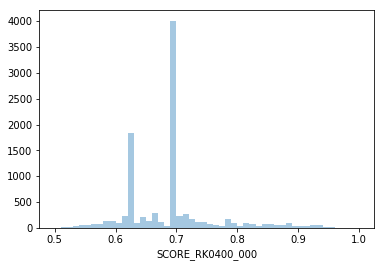

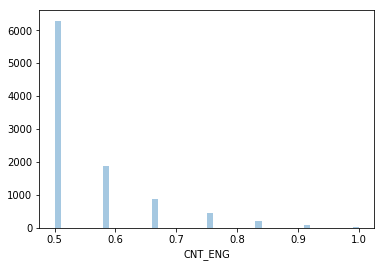

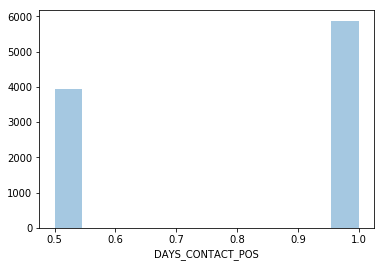

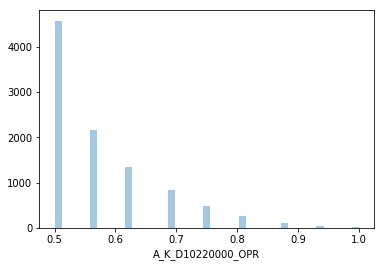

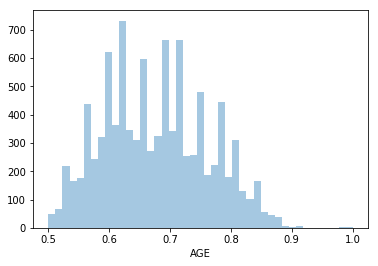

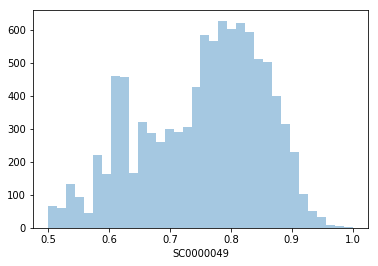

In [7]:
for i in col.tolist() : 
    sns.distplot(pd.DataFrame(data,columns=feature).loc[ : ,  i] , kde = False)
    plt.show()
    

* Robust로 할경우 범위가 factor형인것은 변함이 없고 numeric은 -1.5 ~ 1.5 사이에 있다.
* minmax 는 어떤 거든 다 0 ~ 1 로 보낸다.

In [8]:
input_dim = np.shape(data)[1]

def generator(Z,hsize=[24, 24 , 24 , 24 ],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h2,hsize[2],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h2,hsize[3],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,input_dim )  
        # activation=None  -> linear 라는 의미 => tf.nn.tanh로 변경
    return out


def discriminator(X,hsize=[24, 24 , 24 , 24],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h2,hsize[2],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h2,hsize[3],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,6)
        out = tf.layers.dense(h3,1) # activation=None

    return out, h3

In [9]:

X = tf.placeholder(tf.float32,[None,input_dim ])
Z = tf.placeholder(tf.float32,[None,input_dim ])

In [10]:
G_sample = generator(Z)
Floor_G =  tf.floor(G_sample)
fac1 = tf.slice(Floor_G , [0,0], [-1, len(fac_var)])
g_1 = tf.slice(G_sample , [0,0], [-1, len(fac_var)])
residual = tf.abs(tf.subtract(fac1 , g_1))
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

In [11]:
disc_loss =tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)-0.1) + 
    tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))

gen_loss = tf.add(
    10 * tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits))) , 
    5 * tf.reduce_mean(residual))


In [12]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


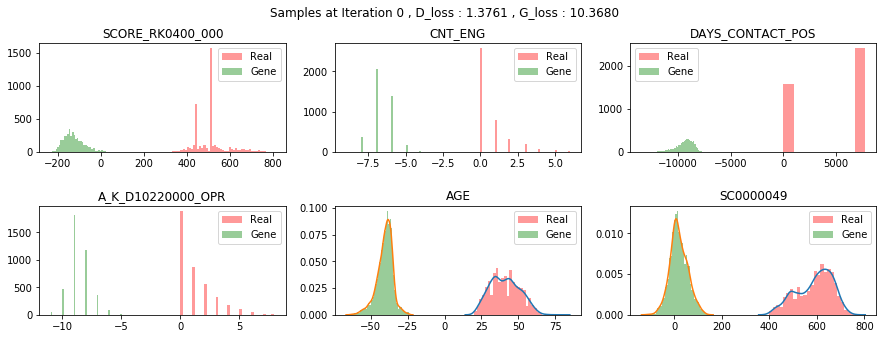

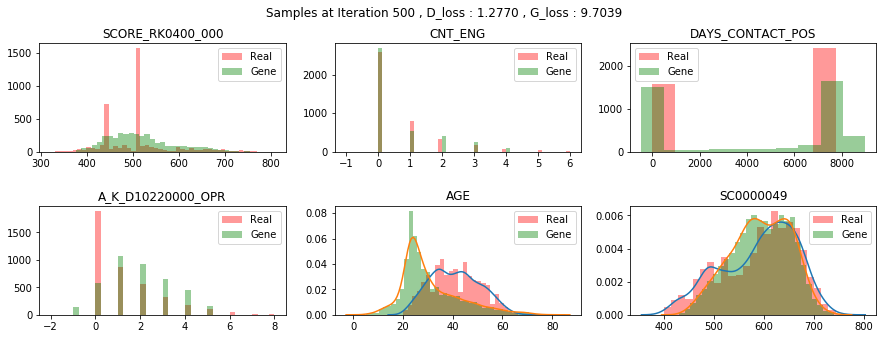

In [ ]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 4000
nd_steps = 10
ng_steps = 10

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])

x_plot = sample_data(n=batch_size)
x_plot = transformer.inverse_transform(x_plot)
f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(20001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size , input_dim )

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    #print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))
    
    if i% 500 == 0:
        fig = plt.figure(figsize = (15,5) )
        ax1 = fig.add_subplot(231)
        ax2 = fig.add_subplot(232)
        ax3 = fig.add_subplot(233)
        ax4 = fig.add_subplot(234)
        ax5 = fig.add_subplot(235)
        ax6 = fig.add_subplot(236)
        ax1.title.set_text(feature[0])
        ax2.title.set_text(feature[1])
        ax3.title.set_text(feature[2])
        ax4.title.set_text(feature[3])
        ax5.title.set_text(feature[4])
        ax6.title.set_text(feature[5])
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        g_plot = transformer.inverse_transform(g_plot)
        g_plot = pd.DataFrame(g_plot , columns= feature )
        g_plot.loc[:,fac_var] = np.around( g_plot.loc[:,fac_var]  , decimals = 0 )
        g_plot = g_plot.values
        sns.distplot(x_plot[:,0],norm_hist =False ,  kde=False , hist_kws ={"color":"r"}, ax = ax1, label = "Real")
        sns.distplot(g_plot[:,0],norm_hist =False ,  kde=False , hist_kws ={"color":"g"}, ax = ax1, label = "Gene")
        sns.distplot(x_plot[:,1],norm_hist =False ,  kde=False , hist_kws ={"color":"r"}, ax = ax2, label = "Real")
        sns.distplot(g_plot[:,1],norm_hist =False ,  kde=False , hist_kws ={"color":"g"}, ax = ax2, label = "Gene")
        sns.distplot(x_plot[:,2],norm_hist =False ,  kde=False , hist_kws ={"color":"r"}, ax = ax3, label = "Real")
        sns.distplot(g_plot[:,2],norm_hist =False ,  kde=False , hist_kws ={"color":"g"}, ax = ax3, label = "Gene")
        sns.distplot(x_plot[:,3],norm_hist =False ,  kde=False , hist_kws ={"color":"r"}, ax = ax4, label = "Real")
        sns.distplot(g_plot[:,3],norm_hist =False ,  kde=False , hist_kws ={"color":"g"}, ax = ax4, label = "Gene")
        sns.distplot(x_plot[:,4],norm_hist =False ,  kde=True , hist_kws ={"color":"r"}, ax = ax5, label = "Real")
        sns.distplot(g_plot[:,4],norm_hist =False ,  kde=True , hist_kws ={"color":"g"}, ax = ax5, label = "Gene")
        sns.distplot(x_plot[:,5],norm_hist =False ,  kde=True , hist_kws ={"color":"r"}, ax = ax6, label = "Real")
        sns.distplot(g_plot[:,5],norm_hist =False ,  kde=True , hist_kws ={"color":"g"}, ax = ax6, label = "Gene")
        ax1.legend()
        ax2.legend()
        ax3.legend()
        ax4.legend()
        ax5.legend()
        ax6.legend()

#         xax = sns.distplot(x_plot, kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"})
#         gax = sns.distplot(g_plot, kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"})

        #plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.suptitle('Samples at Iteration %d , D_loss : %.4f , G_loss : %.4f'%(i,dloss,gloss) )
        plt.subplots_adjust(top =0.88 , hspace = 0.5)
        #plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.show()

#         plt.figure()
#         rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
#         rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
#         grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
#         grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


#         plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))
#         plt.title('Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         #plt.savefig('../plots/features/feature_transform_%d.png'%i)
#         plt.show()

#         plt.figure()

#         rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
#         rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
#         grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
#         grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

#         plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))

#         plt.title('Centroid of Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         #plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
#         plt.show()

f.close()

# German Data Test
* 4개(괜찬) -> 6개 (불완전) 

* 처음에 Scaling 안하고 학습하니 진짜 잘 안됨
* 하고 나서는 그럴 듯하게 나오기 시작함
* Discriminator Loss가 항상 너무 낮게 나옴 이걸 어느정도 해결하고 싶음 
* 일단은 새로운 Loss를 찾아봐야 할 것 같음 wgan-gp 같은 것 
### **Weight Loss**
* discriminator에도 5 정도 줬는데 잘 안먹히는 듯.
    * 아예 10을 줘버림. 개인적으로 궁금한 건 저렇게 weight를 주면 잘 반영이 되는지 궁금
    * mode collapse 같은 것이 발생한다 ( 봉우리 사이가 너무 넓을 때 )
* tf.ones_like(r_logits)-0.1 를 주고 factor variable 에 대해서만 residual 계산하는 걸로 변형
    * 10을 곱해서 Loss를 해주는 것이 좋다.
    * numeric 분포를 따라가면 factor 를 못 따라간다.
### **Scaling**
* minmax scaling ( 0 ~ 1 )
    * scaling (-1 ,1 )로 하고 tanh 함수를 마지막에 씌우면 어떻게 될까?
        * 초반에 똥같은 결과만 내뱉는 중 그래서 tanh 제거
            * 왜 여기선 안먹는 걸까? 이론상 맞는데...
            * tanh 안쓰면 괜찬은 결과 출력 됨
       * 극단적인 값들이 있을 땐 극단값의 범위를 좀 더 줄여줘서 해보는건 어떨까
           * ( 1/2 ~ 1 ) 로 하니까 아까 학습이 안되던 DAYS_CONTACT_POS 가 잘 되는 것을 확인 함. 
           * residual 값 자체가 작아지기 때문에 걱정했는데 다행이다.(그럼 여기에 좀 더 가중치를 준다면?! 
    * 지금 discriminator도 sigmoid를 안씌운 상태이긴 함.
* robust scaling ( -1.5 ~ 1.5 ) ( factor은 그대로 유지되는 경향)

> 반복되는 현상은 초반에는 괜찮은데. 나중에 완전 이상한 곳으로 빠지게 된다.